/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


0 0.6595319 0.69655377 0.6902255
0 0.573903 0.7042692 0.6830544
0 0.51645035 0.7198633 0.67041206
0 0.45821372 0.7450594 0.6536974
0 0.39646387 0.7718394 0.64139223
0 0.36364603 0.7942529 0.6428528
0 0.3305431 0.7793318 0.672083
0 0.32322168 0.722971 0.75220686
0 0.3196554 0.64657336 0.8703712
0 0.2791121 0.5375161 0.99924576
0 0.27784485 0.48488837 1.0685102
0 0.38214755 0.527433 0.9294196
0 0.3013044 0.6239333 0.79562604
0 0.28469667 0.73993146 0.685611
0 0.26456967 0.887779 0.57942927
0 0.29115546 1.0343634 0.51968443
0 0.1750777 1.0670761 0.5188303
0 0.1768642 0.9897991 0.58196974
0 0.1779308 0.86990386 0.6976008
0 0.12996936 0.7175204 0.8838866
0 0.102362886 0.52328414 1.139425
0 0.108395696 0.39194706 1.3427474
0 0.092445046 0.3610158 1.3366187
0 0.086001605 0.44961876 1.0789399
0 0.07709812 0.5860669 0.8449732
0 0.05833596 0.72340745 0.68998015
0 0.048882328 0.83855766 0.5959079
0 0.0512124 0.908375 0.5581315
0 0.08639786 0.9369089 0.5515049
0 0.071760386 0.9286605 0.58462596
0 

0 0.6307739 0.7815051 0.705845
0 0.6597372 0.7706226 0.68204063
0 0.6535617 0.77567005 0.7072133
0 0.7139727 0.7669891 0.71372247
0 0.67789906 0.7386496 0.72177905
0 0.7142046 0.7231909 0.7700324
0 0.70696044 0.6761768 0.8215042
0 0.7409344 0.6148319 0.88416624
0 0.70185757 0.5843289 0.90876913
0 0.6980592 0.54940957 0.947334
0 0.6946052 0.52802634 1.0063576
0 0.6776383 0.52000725 0.99495745
0 0.7136463 0.5373095 0.97710997
0 0.692274 0.55264556 0.9211876
0 0.6504953 0.66432244 0.84784365
0 0.66389257 0.6847116 0.7669224
0 0.65022194 0.73753667 0.72913015
0 0.6283212 0.7797718 0.65504026
0 0.6650115 0.8538501 0.6253377
0 0.6581257 0.8236586 0.63233644
0 0.65539014 0.815202 0.6367134
0 0.6980654 0.80148077 0.6630492
0 0.68444276 0.79131925 0.66466653
0 0.67911375 0.7852519 0.6932704
0 0.6881258 0.71829104 0.722511
0 0.6926464 0.7067158 0.72868997
0 0.6652529 0.6816693 0.75454885
0 0.69893396 0.6758891 0.7673813
0 0.6728351 0.66756886 0.7985406
0 0.6416963 0.62211 0.8225114
0 0.65496063 

NameError: name 'np' is not defined

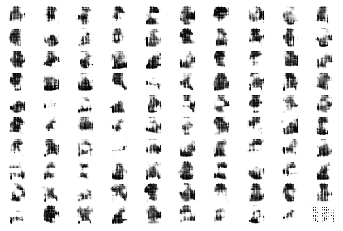

In [10]:

from datetime import datetime

from numpy import expand_dims
from numpy.random import randint
from tensorflow.keras.datasets.fashion_mnist import load_data
import tensorflow as tf
import sys

sys.path.append("..")
from src.models.c_dcgan import GAN
from src.models.train_helpers import CGanTrainer
import matplotlib.pyplot as plt

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


def load_real_samples():
    (train_X, train_y), (_, _) = load_data()
    x = expand_dims(train_X, axis=-1)
    x = x.astype('float32')
    x = (x - 127.5) / 127.5
    return [x, train_y]


def generate_real_samples(dataset, n_samples):
    images, labels = dataset
    ix = randint(0, images.shape[0], n_samples)
    images, labels = images[ix], labels[ix]
    return [images, labels]


# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, callbacks, n_epochs=100, n_batch=128):

    logdir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    file_writer = tf.summary.create_file_writer(logdir + "/metrics")

    trainer = CGanTrainer(d_model, g_model, gan_model, batch_size=n_batch, n_classes=10, noise_dim=latent_dim)
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    callbacks.on_train_begin()
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            # callback.on_batch_begin(i)
            [x_real, labels_real] = generate_real_samples(dataset, half_batch)
            real_loss, fake_loss, gan_loss = trainer.train_step(x_real, labels_real, i)
            # callbacks.on_batch_end(
            #     i,
            #     logs={'real_loss': real_loss, 'fake_loss': fake_loss, 'gan_loss': gan_loss})

        with file_writer.as_default():
            tf.summary.scalar('loss', data=real_loss, step=i)
            tf.summary.scalar('fake loss', data=fake_loss, step=i)
            tf.summary.scalar('gan loss', data=gan_loss, step=i)
            a = trainer.create_fig(i)
            plt.imshow(a)
            a = np.reshape(train_images[0], (-1, a.shape[1], a.shape[2], 4))

            tf.summary.image('gan loss', data=a, step=i)
        
        plt.imshow(trainer.create_fig(i))

        print('EPOCH:', i)
    # callbacks.on_train_end('_')
    g_model.save('cgan_generator.h5')


latent_dim = 100
gan = GAN((28, 28, 1))
d_model = gan.discriminator
g_model = gan.generator
gan_model = gan.combined
dataset = load_real_samples()

log_path = './log'
callback = tf.keras.callbacks.TensorBoard(log_path)
callback.set_model(gan_model)

# train model
train(g_model, d_model, gan_model, dataset, latent_dim, callback, 3)

In [1]:
%load_ext tensorboard
%tensorboard --logdir logs --bind_all